In [173]:
import numpy as np
from numpy import zeros, diag, eye, log, sqrt, vstack, mean, save
from scipy.stats import multivariate_normal as MVN
from numpy.linalg import solve, norm
from numpy.random import normal, rand
from utils import n_unique, MVN_scatters, quick_MVN_scatter, ESS_univariate

In [8]:
def log_uniform_kernel(xi, epsilon):
    """Log density of uniform kernel. """
    with np.errstate(divide='ignore'):
        return log((abs(target.logpdf(xi) - z0) <= epsilon).astype('float64'))
    
def logprior_uniform(xi):
    """Log density for uniform prior p(xi) of parameters and latents U([-5,5]x[-5,5])."""
    with np.errstate(divide='ignore'):
        return log((abs(xi) <= 5.0).all().astype('float64'))

def logprior_uniform_all(xi):
    """Log density for uniform prior p(xi) of parameters and latents U([-5,5]x[-5,5])."""
    with np.errstate(divide='ignore'):
        return log((abs(xi) <= 5.0).all(axis=1).astype('float64'))
    
def log_abc_posterior(xi):
    """Log density of ABC posterior. Product of (param-latent) prior and uniform kernel."""
    return logprior_uniform(xi) + log_uniform_kernel(xi, epsilon)

def log_abc_posterior_all(xi):
    """Log density of ABC posterior. Product of (param-latent) prior and uniform kernel."""
    return logprior_uniform_all(xi) + log_uniform_kernel(xi, epsilon)
    
def grad_log_simulator(xi):
    """Gradient of log simulator N(mu, Sigma)."""
    return - solve(Sigma, xi)

In [21]:
# Target distribution is a diagonal MVN
Sigma0 = diag([1.0, 5.0])
coef = 1.0
Sigma = coef * Sigma0
target = MVN(zeros(2), Sigma)

# Initial point on z0-contour
x0 = normal(size=2)                           # Keep initial point the same
z0 = target.logpdf(x0)                        # Feed through simulator

# Proposal for velocity in HUG/HUG_AR
q = MVN(zeros(2), eye(2))


# Settings
T = 1.5
B = 5
N = 10000
alpha = 0.9
epsilon = 0.000001

In [120]:
def test(x00, T, B, N, alpha, q, logpi, grad_log_pi):
    # Sample all spherical velocities
    velocities = q.rvs(N)
    logus = np.log(rand(N))
    # Housekeeping
    hug  = x00
    thug = x00
    rhug = x00
    ahug  = zeros(N)
    athug = zeros(N)
    arhug = zeros(N)
    Dpots_hug = zeros(N)
    Dkins_hug = zeros(N)
    Dpots_thug = zeros(N)
    Dkins_thug = zeros(N)
    Dpots_rhug = zeros(N)
    Dkins_rhug = zeros(N)
    Dpdf_hug = zeros(N)
    Dpdf_thug = zeros(N)
    Dpdf_rhug = zeros(N)
    delta = T / B
    # HUG
    x0 = x00
    for i in range(N):
        v0 = velocities[i]    # Draw velocity
        v, x = v0, x0         # Housekeeping

        for _ in range(B):
            # Move
            x = x + delta*v/2 
            # Reflect
            g = grad_log_pi(x)
            ghat = g / norm(g)
            v = v - 2*(v @ ghat) * ghat
            # Move
            x = x + delta*v/2
        Dpot = logpi(x) - logpi(x0) 
        Dkin = q.logpdf(v) - q.logpdf(v0)
        Dpots_hug[i] = Dpot
        Dkins_hug[i] = Dkin
        Dpdf_hug[i] = abs(target.logpdf(x) - target.logpdf(x0))
        loga = Dpot + Dkin
        if logus[i] <= loga:
            hug = vstack((hug, x))
            ahug[i] = 1         # Accepted!
            x0 = x
        else:
            hug = vstack((hug, x0))
            ahug[i] = 0         # Rejected
        
    # THUG
    x0 = x00
    for i in range(N):
        v0s = velocities[i]                   # Draw velocity spherically
        g = grad_log_pi(x0)              # Compute gradient at x0
        g = g / norm(g)                  # Normalize
        v0 = v0s - alpha * g * (g @ v0s) # Tilt velocity
        v, x = v0, x0                    # Housekeeping

        for _ in range(B):
            x = x + delta*v/2           # Move to midpoint
            g = grad_log_pi(x)          # Compute gradient at midpoint
            ghat = g / norm(g)          # Normalize 
            v = v - 2*(v @ ghat) * ghat # Reflect velocity using midpoint gradient
            x = x + delta*v/2           # Move from midpoint to end-point
        # Unsqueeze the velocity
        g = grad_log_pi(x)
        g = g / norm(g)
        v = v + (alpha / (1 - alpha)) * g * (g @ v)
        # In the acceptance ratio must use spherical velocities!! Hence v0s and the unsqueezed v
        Dpot = logpi(x) - logpi(x0)
        Dkin = q.logpdf(v)  - q.logpdf(v0s)
        loga = Dpot + Dkin
        Dpots_thug[i] = Dpot
        Dkins_thug[i] = Dkin
        Dpdf_thug[i] = abs(target.logpdf(x) - target.logpdf(x0))
        if logus[i] <= loga:
            thug = vstack((thug, x))
            athug[i] = 1         # Accepted!
            x0 = x
        else:
            thug = vstack((thug, x0))
            athug[i] = 0         # Rejected
    # ROTATED HUG
    x0 = x00
    for i in range(N):
        v0s = velocities[i]              # Draw velocity spherically
        g = grad_log_pi(x0)              # Compute gradient at x0
        g = g / norm(g)                  # Normalize
        v0 = v0s - alpha * g * (g @ v0s) # Tilt velocity
        v0 = v0 * norm(v0s) / norm(v0)  # Rescale.
        v, x = v0, x0                    # Housekeeping
            
        for _ in range(B):
            x = x + delta*v/2           # Move to midpoint
            g = grad_log_pi(x)          # Compute gradient at midpoint
            ghat = g / norm(g)          # Normalize 
            v = v - 2*(v @ ghat) * ghat # Reflect velocity using midpoint gradient
            x = x + delta*v/2           # Move from midpoint to end-point
        # Unsqueeze the velocity
        g = grad_log_pi(x)
        g = g / norm(g)
        vs = v + (alpha / (1 - alpha)) * g * (g @ v)
        # Rescale
        vs = vs * norm(v0s) /norm(vs)
        # In the acceptance ratio must use spherical velocities!! Hence v0s and the unsqueezed v
        Dpot = logpi(x) - logpi(x0)
        Dkin = q.logpdf(vs)  - q.logpdf(v0s)
        loga = Dpot + Dkin
        Dpots_rhug[i] = Dpot
        Dkins_rhug[i] = Dkin
        Dpdf_rhug[i] = abs(target.logpdf(x) - target.logpdf(x0))
        if logus[i] <= loga:
            rhug = vstack((rhug, x))
            arhug[i] = 1         # Accepted!
            x0 = x
        else:
            rhug = vstack((rhug, x0))
            arhug[i] = 0         # Rejected
    return hug[1:], thug[1:], rhug[1:], ahug, athug, arhug, Dpots_hug, Dpots_thug, Dpots_rhug, Dkins_hug, Dkins_thug, Dkins_rhug, Dpdf_hug, Dpdf_thug, Dpdf_rhug,logus

In [260]:
N = 10000
epsilon = 0.01
alpha = 0.9
multiplier = 1.0
T = 2.0 * multiplier
B = int(5 * multiplier)
x0 = normal(size=2)                           # Keep initial point the same
z0 = target.logpdf(x0)                        # Feed through simulator
hug, thug, rhug, ahug, athug, arhug, Dpots_hug, Dpots_thug, Dpots_rhug, Dkins_hug, Dkins_thug, Dkins_rhug, Dpdf_hug, Dpdf_thug, Dpdf_rhug,logus = test(
    x0, T, B, N, alpha, q, log_abc_posterior, grad_log_simulator
)

In [261]:
print("EPSILON: ", epsilon)
print("ALPHA:   ", alpha)
print("T:       ", T)
print("B:       ", B)
print("delta:   ", T/B)
print("-"*50)
print("\tABS LOG-PDF\tAP\tUNIQUE\t\tKIN\tPOT\ttheta-ESS\tuESS")
print("HUG  \t{:.5f}\t\t{:.2%}\t{:4d}\t{:.3e}\t{:5d}\t{:.2f}\t\t{:.2f}".format(mean(Dpdf_hug), mean(ahug), n_unique(hug), mean(Dkins_hug), sum(Dpots_hug == 0), ESS_univariate(hug[:, 0]), ESS_univariate(hug[:, 1])))
print("THUG \t{:.5f}\t\t{:.2%}\t{:4d}\t{:.3e}\t{:5d}\t{:.2f}\t\t{:.2f}".format(mean(Dpdf_thug), mean(athug), n_unique(thug), mean(Dkins_thug), sum(Dpots_thug == 0), ESS_univariate(thug[:, 0]), ESS_univariate(thug[:, 1])))
print("RHUG \t{:.5f}\t\t{:.2%}\t{:4d}\t{:.3e}\t{:5d}\t{:.2f}\t\t{:.2f}".format(mean(Dpdf_rhug), mean(arhug), n_unique(rhug), mean(Dkins_rhug), sum(Dpots_rhug == 0), ESS_univariate(rhug[:, 0]), ESS_univariate(rhug[:, 1])))

EPSILON:  0.01
ALPHA:    0.9
T:        2.0
B:        5
delta:    0.4
--------------------------------------------------
	ABS LOG-PDF	AP	UNIQUE		KIN	POT	theta-ESS	uESS
HUG  	0.00954		65.87%	6587	-1.945e-17	 6587	519.66		274.53
THUG 	0.00618		69.14%	6914	-1.615e+00	 7591	119.97		131.97
RHUG 	0.01043		64.81%	6481	-3.619e-18	 6481	434.29		513.92


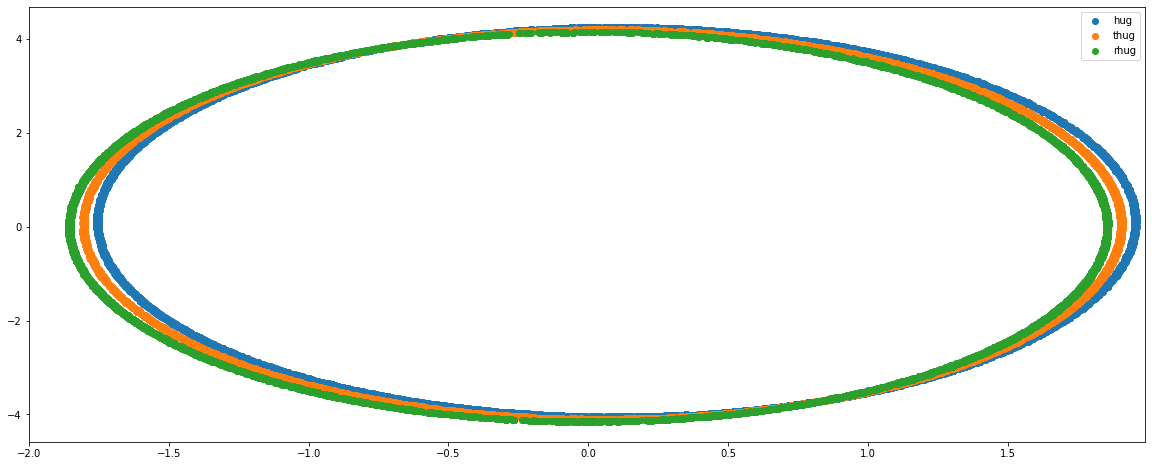

In [262]:
MVN_scatters([hug+0.1, thug+0.05, rhug], target, labels=['hug', 'thug', 'rhug'], levels=[target.pdf(x0)], lw=1, alpha=0.5,
            xlims=[-2,2], ylims=[-4,4])

In [314]:
def involution_rhug(x0, v0, delta=0.3, alpha=0.9):
    x, v = x0, v0
    # Rotate
    g = grad_log_simulator(x) / norm(grad_log_simulator(x))
    v = v - alpha * (v @ g) * g
    v = v * norm(v0) / norm(v)
    # Move 
    x = x + delta * v / 2
    # Reflect
    g = grad_log_simulator(x) / norm(grad_log_simulator(x))
    v = v - 2 * (v @ g) * g
    # Move
    x = x + delta * v / 2
    # Unrotate
    g = grad_log_simulator(x) / norm(grad_log_simulator(x))
    v = v + (alpha / (1-alpha)) * (v @ g) * g
    v = v * norm(v0) / norm(v)
    return x, -v  # Return negated velocity

In [315]:
def involution_newrhug(x0, v0, delta=0.3, alpha=0.9):
    x, v = x0, v0
    # Squeeze
    g = grad_log_simulator(x) / norm(grad_log_simulator(x))
    v = v - alpha * (v @ g) * g
    normv = norm(v)
    v = v / normv
    # Move 
    x = x + delta * v / 2
    # Reflect
    g = grad_log_simulator(x) / norm(grad_log_simulator(x))
    v = v - 2 * (v @ g) * g
    # Move
    x = x + delta * v / 2
    # Unrotate
    g = grad_log_simulator(x) / norm(grad_log_simulator(x))
    v = v * normv
    v = v + (alpha / (1-alpha)) * (v @ g) * g
    return x, -v  # Return negated velocity

In [316]:
def involution_thug(x0, v0, delta=0.3, alpha=0.9):
    x, v = x0, v0
    # Rotate
    g = grad_log_simulator(x) / norm(grad_log_simulator(x))
    v = v - alpha * (v @ g) * g
    # Move 
    x = x + delta * v / 2
    # Reflect
    g = grad_log_simulator(x) / norm(grad_log_simulator(x))
    v = v - 2 * (v @ g) * g
    # Move
    x = x + delta * v / 2
    # Unrotate
    g = grad_log_simulator(x) / norm(grad_log_simulator(x))
    v = v + (alpha / (1-alpha)) * (v @ g) * g
    return x, -v  # Return negated velocity

In [347]:
v0 = q.rvs()
a = 0.999999
d = 0.3
x0, v0

(array([ 1.853805  , -0.18040724]), array([ 0.0079663 , -0.84759351]))

In [348]:
x11, v11 = involution_rhug(x0, v0, alpha=a, delta=d)
x12, v12 = involution_thug(x0, v0, alpha=a, delta=d)
x13, v13 = involution_newrhug(x0, v0, alpha=a, delta=d)

In [349]:
norm(v0) - norm(v11)

-2.220446049250313e-16

In [350]:
norm(v0) - norm(v12)

-84.17660480846806

In [351]:
norm(v0) - norm(v13)

-126.57012142114328